In [1]:
import torch
import torch.nn as nn
from utils import get_data, min_max_normalize, prepare_data, create_dataloaders, set_seed
from model import MembraneModel, ModelPredictor
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd

# set seed for reproducibility
set_seed(42)

# Pfade
data_csv = '../../../data/interpolation/auswertung_gesamt_8N_10N_12N_15N_17N_18N_20N.csv'

In [2]:
data = get_data(data_csv)
norm_data, mins, maxs = min_max_normalize(data)

In [3]:
data.head()

,Datei_ID,X,Y,F,Sensor R1,Sensor R2,Sensor R3,Sensor R4,Sensor R5,Sensor R6,Sensor R7,Sensor R8
0,0,-290.0,290.0,8.0,3.204525,3.736075,2.075750,3.186575,3.381575,3.499850,3.244225,3.200625
1,1,-290.0,232.0,8.0,3.168300,3.681725,2.316125,3.176025,3.418725,3.475375,3.233525,3.199025
2,2,-290.0,174.0,8.0,3.174200,3.553550,2.512250,3.165550,3.420850,3.426800,3.222500,3.206325
3,3,-290.0,116.0,8.0,3.169525,3.421750,2.574925,3.159475,3.406800,3.351650,3.208675,3.211225
4,4,-290.0,58.0,8.0,3.223000,3.062850,2.820825,3.139875,3.379850,3.225300,3.178675,3.221750


In [4]:
norm_data.head()

,Datei_ID,X,Y,F,Sensor R1,Sensor R2,Sensor R3,Sensor R4,Sensor R5,Sensor R6,Sensor R7,Sensor R8
0,0,-290.0,290.0,8.0,0.602263,0.868038,0.037875,0.593287,0.690788,0.749925,0.622113,0.600313
1,1,-290.0,232.0,8.0,0.584150,0.840863,0.158062,0.588013,0.709362,0.737688,0.616763,0.599512
2,2,-290.0,174.0,8.0,0.587100,0.776775,0.256125,0.582775,0.710425,0.713400,0.611250,0.603163
3,3,-290.0,116.0,8.0,0.584763,0.710875,0.287462,0.579738,0.703400,0.675825,0.604337,0.605613
4,4,-290.0,58.0,8.0,0.611500,0.531425,0.410413,0.569937,0.689925,0.612650,0.589338,0.610875


In [5]:
punkt1 = data.iloc[3,-8:].values

## Splitting the Data

In [6]:
batch_size = 64

# Data with x and y only
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(norm_data, targets='xy')
train_loader_xy, val_loader_xy, test_loader_xy = create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=batch_size)
# Data with F only
X_train, X_val, X_test, y_train, y_val, y_test = prepare_data(norm_data, targets='f')
train_loader_f, val_loader_f, test_loader_f = create_dataloaders(X_train, X_val, X_test, y_train, y_val, y_test, batch_size=batch_size)

In [7]:
predictor_xy = ModelPredictor(model_class=MembraneModel, model_path="../../../models/final_models/model_xy.pt", output_dim=2, mins=mins, maxs=maxs)
predictor_f = ModelPredictor(model_class=MembraneModel, model_path="../../../models/final_models/model_f.pt", output_dim=1, mins=mins, maxs=maxs)
predictor_xyf = ModelPredictor(model_class=MembraneModel, model_path="../../../models/final_models/model_xyf.pt", output_dim=3, mins=mins, maxs=maxs)

/tmp/ipykernel_63455/2424835462.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


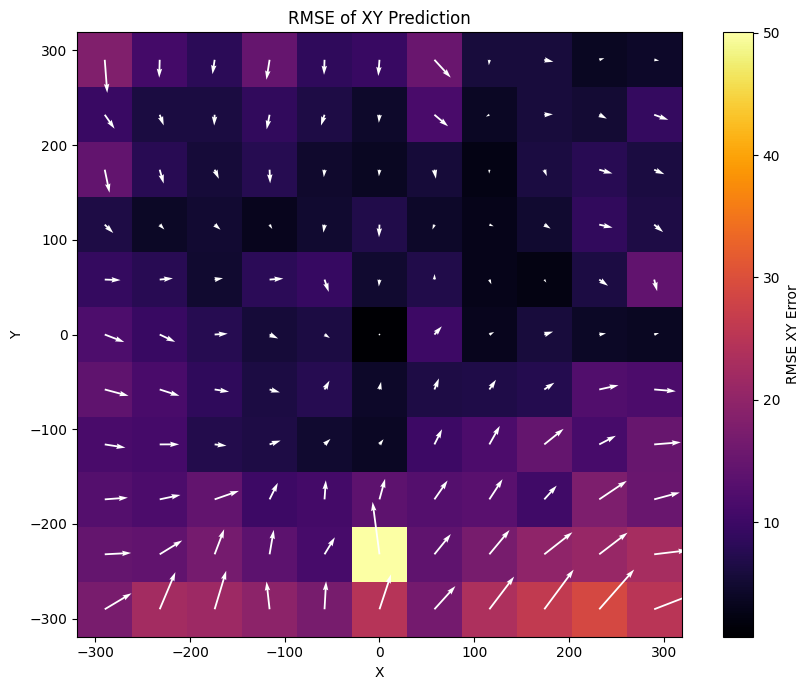

In [8]:
xy_errors = []

for idx, row in data.iterrows():
    label_point = np.array([row.iloc[1], row.iloc[2]])
    predicted_point = np.array(predictor_xy.predict(row[-8:].values))
    dx = predicted_point[0] - label_point[0] # Vektorieller Fehler
    dy = predicted_point[1] - label_point[1] # Vektorieller Fehler
    err = np.linalg.norm([dx, dy])
    error = np.linalg.norm(label_point - predicted_point)
    xy_errors.append([label_point[0], label_point[1], dx, dy, error])

# xy_errors -> all data
# xy_errors[0:121] -> data with 8N
# xy_errors[121:242] -> data with 10N
df_errors = pd.DataFrame(xy_errors, columns=['x', 'y', 'dx', 'dy', 'error'])

df_rmse = (
    df_errors.groupby(['x', 'y'])
          .apply(lambda g: pd.Series({
              "rmse": np.sqrt(np.mean(g["error"]**2)),
              "dx_mean": np.mean(g["dx"]),
              "dy_mean": np.mean(g["dy"])
          }))
          .reset_index()
)

# Plotting heatmap of RMSE errors
xu = np.sort(df_rmse["x"].unique())
yu = np.sort(df_rmse["y"].unique())

nx = len(xu)
ny = len(yu)

Z = np.full((ny, nx), np.nan)
DX = np.full((ny, nx), 0.0)
DY = np.full((ny, nx), 0.0)


for _, row in df_rmse.iterrows():
    ix = np.where(xu == row["x"])[0][0]
    iy = np.where(yu == row["y"])[0][0]

    Z[iy, ix] = row["rmse"]
    DX[iy, ix] = row["dx_mean"]
    DY[iy, ix] = row["dy_mean"]

plt.figure(figsize=(9, 7))
c = plt.pcolormesh(xu, yu, Z, cmap="inferno", shading="auto")

#sizes = 20 + 10 * df_rmse["rmse"]
#plt.scatter(df_rmse["x"], df_rmse["y"], edgecolor="red", facecolor="none", s=sizes)
plt.quiver(xu, yu, DX, DY, color='white', angles='xy', scale_units='xy', scale=0.5, width=0.003)

plt.colorbar(c, label="RMSE XY Error")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("RMSE of XY Prediction")
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.savefig("../../../figs/xy_rmse_heatmap.png", dpi=160)


/tmp/ipykernel_63455/761178302.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: np.sqrt(np.mean(g["error"]**2)))


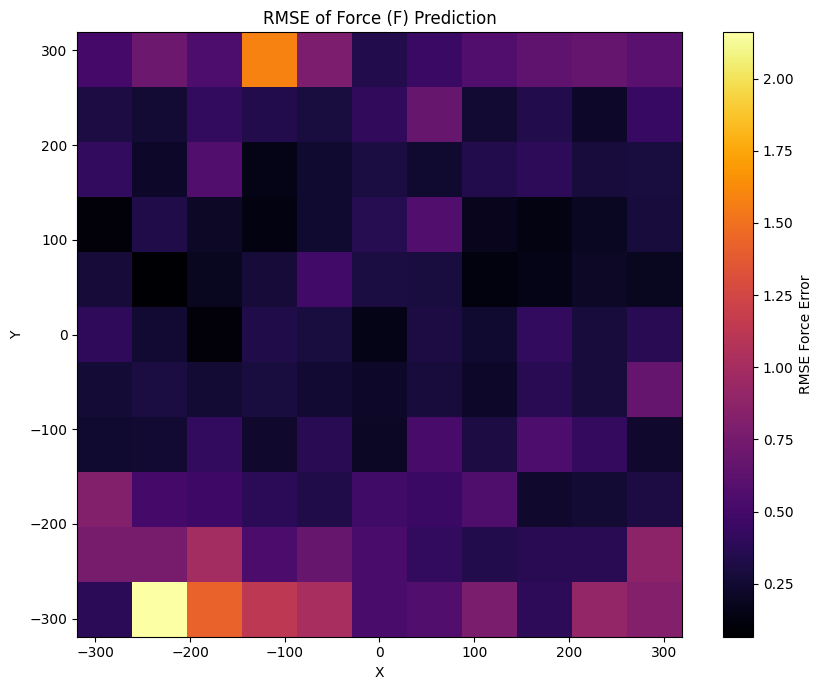

In [9]:
f_errors = []

for idx, row in data.iterrows():
    true_f = row.iloc[3]
    pred_f = predictor_f.predict(row[-8:].values)[0]

    err = np.abs(pred_f - true_f)          # absoluter Fehler
    f_errors.append([row.iloc[1], row.iloc[2], err])

df_f_errors = pd.DataFrame(f_errors, columns=['x', 'y', 'error'])

# RMSE pro (x, y)
df_f_rmse = (
    df_f_errors.groupby(['x', 'y'])
               .apply(lambda g: np.sqrt(np.mean(g["error"]**2)))
               .reset_index(name="rmse")
)

# --- Heatmap-Gitter vorbereiten ---
xu = np.sort(df_f_rmse["x"].unique())
yu = np.sort(df_f_rmse["y"].unique())

nx = len(xu)
ny = len(yu)

Z_f = np.full((ny, nx), np.nan)

for _, row in df_f_rmse.iterrows():
    ix = np.where(xu == row["x"])[0][0]
    iy = np.where(yu == row["y"])[0][0]
    Z_f[iy, ix] = row["rmse"]

# --- Plot ---
plt.figure(figsize=(9, 7))
c = plt.pcolormesh(xu, yu, Z_f, cmap="inferno", shading="auto")

#sizes = 20 + 1000 * df_f_rmse["rmse"]
#plt.scatter(df_f_rmse["x"], df_f_rmse["y"], edgecolor="white", facecolor="none", s=sizes)

plt.colorbar(c, label="RMSE Force Error")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("RMSE of Force (F) Prediction")
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.savefig("../../../figs/force_rmse_heatmap.png", dpi=160)



/tmp/ipykernel_63455/3695613977.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


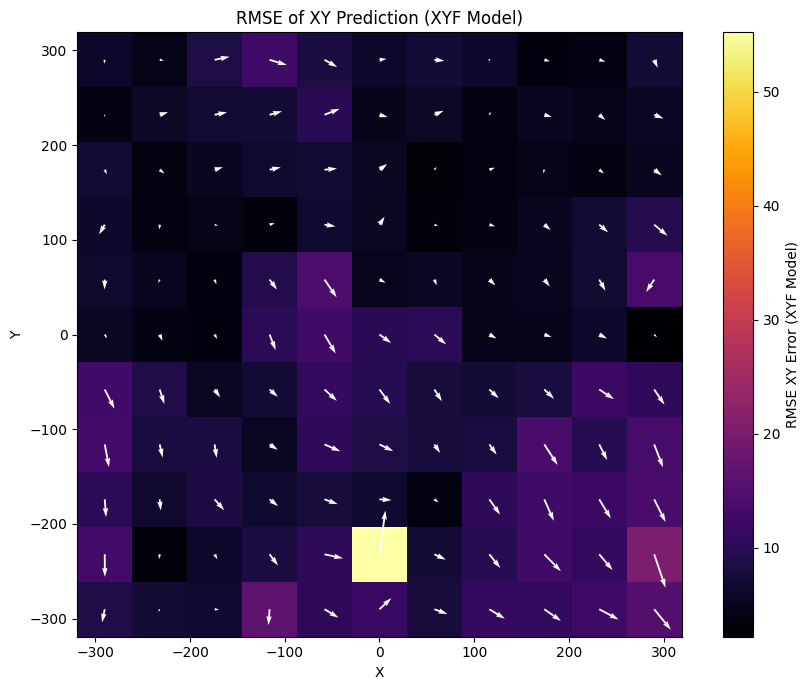

In [10]:
xyf_errors = []

for idx, row in data.iterrows():
    label_point = np.array([row.iloc[1], row.iloc[2]])

    # predictor_xyf -> predicts [x_pred, y_pred, f_pred]
    xyf_pred = predictor_xyf.predict(row[-8:].values)

    predicted_point = np.array([xyf_pred[0], xyf_pred[1]])
    dx = predicted_point[0] - label_point[0]
    dy = predicted_point[1] - label_point[1]
    error = np.sqrt(dx**2 + dy**2)

    xyf_errors.append([label_point[0], label_point[1], dx, dy, error])


# === DataFrame ===
df_errors_xyf = pd.DataFrame(xyf_errors, columns=['x', 'y', 'dx', 'dy', 'error'])

df_rmse_xyf = (
    df_errors_xyf.groupby(['x', 'y'])
        .apply(lambda g: pd.Series({
            "rmse": np.sqrt(np.mean(g["error"]**2)),
            "dx_mean": np.mean(g["dx"]),
            "dy_mean": np.mean(g["dy"])
        }))
        .reset_index()
)

# === Prepare grid ===
xu = np.sort(df_rmse_xyf["x"].unique())
yu = np.sort(df_rmse_xyf["y"].unique())
nx = len(xu)
ny = len(yu)

Z = np.full((ny, nx), np.nan)
DX = np.full((ny, nx), 0.0)
DY = np.full((ny, nx), 0.0)

for _, row in df_rmse_xyf.iterrows():
    ix = np.where(xu == row["x"])[0][0]
    iy = np.where(yu == row["y"])[0][0]
    Z[iy, ix] = row["rmse"]
    DX[iy, ix] = row["dx_mean"]
    DY[iy, ix] = row["dy_mean"]

# === Plot ===
plt.figure(figsize=(9, 7))
c = plt.pcolormesh(xu, yu, Z, cmap="inferno", shading="auto")

#sizes = 20 + 10 * df_rmse_xyf["rmse"]
#plt.scatter(df_rmse_xyf["x"], df_rmse_xyf["y"], edgecolor="red", facecolor="none", s=sizes)
plt.quiver(xu, yu, DX, DY, color='white', angles='xy', scale_units='xy', scale=0.5, width=0.003)

plt.colorbar(c, label="RMSE XY Error (XYF Model)")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("RMSE of XY Prediction (XYF Model)")
plt.gca().set_aspect("equal")
plt.tight_layout()
plt.savefig("../../../figs/xyf_rmse_heatmap.png", dpi=160)
